In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from deepface import DeepFace as df
from retinaface import RetinaFace as m
from PIL import Image
import imagehash
import pandas as pd
from pymongo import MongoClient
from deepface.commons import functions
from tqdm import tqdm
import mediapipe as mp

576 576


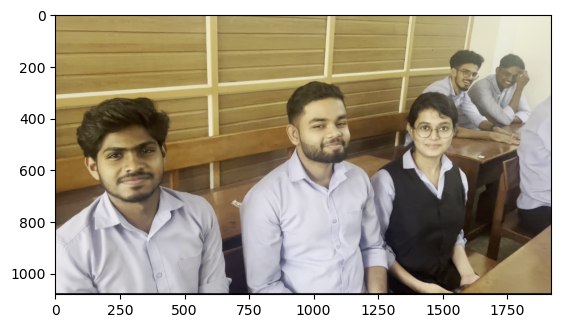

In [2]:
video = cv2.VideoCapture('Data/Video/input2.MOV')
count = 0
frames_arr = []
while video.isOpened():
    ret, frame = video.read()

    if not ret:
        break
    frames_arr.append(frame)                                         # Frames stored in frames_arr
    count += 1
video.release()
print(len(frames_arr), count)


img = frames_arr[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [3]:
frames = []
frames.append(frames_arr[0])
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(1, len(frames_arr)):
    keypoints1, descriptors1 = orb.detectAndCompute(frames[-1], None)
    keypoints2, descriptors2 = orb.detectAndCompute(frames_arr[i], None)
    matches = bf.match(descriptors1, descriptors2)
    #matches = sorted(matches, key=lambda x: x.distance)
    
    if len(matches) < 200:
        frames.append(frames_arr[i])
print(len(frames))

55


In [4]:
%%time
detected_faces = []
mp_face_detction = mp.solutions.face_detection
for frame in frames:
    with mp_face_detction.FaceDetection(model_selection = 1, min_detection_confidence = 0.5) as face_detection:
        results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        for detection in results.detections:
            box = detection.location_data.relative_bounding_box
            x_start, y_start = int(box.xmin * img.shape[1]), int(box.ymin * img.shape[0])
            x_end, y_end = int((box.xmin + box.width) * img.shape[1]), int((box.ymin + box.height) * img.shape[0])

            if x_start < 0 or y_start < 0:
                continue

            face = frame[y_start:y_end, x_start:x_end]
            face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            detected_faces.append(face)
print(len(detected_faces))


266
CPU times: total: 2.25 s
Wall time: 2.75 s


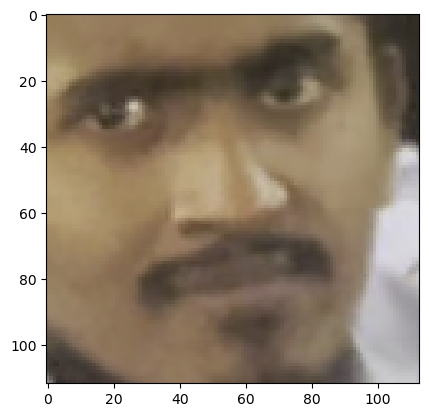

In [5]:
plt.imshow(detected_faces[200])

258


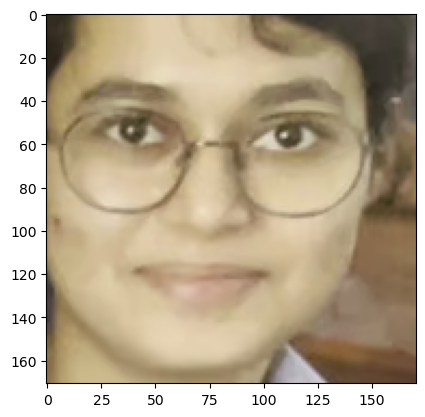

In [6]:
faces = []
faces.append(cv2.convertScaleAbs(detected_faces[0]))
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(1, len(detected_faces)):
    img2 = cv2.convertScaleAbs(detected_faces[i])

    

    keypoints1, descriptors1 = orb.detectAndCompute(faces[-1], None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    if descriptors2 is None:
        
        continue

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(descriptors1, descriptors2)

    #matches = sorted(matches, key=lambda x: x.distance)

    if len(matches) < 200:
        faces.append(detected_faces[i])

detected_faces[:]=faces[:]
print(len(detected_faces))

plt.imshow(detected_faces[2])

In [8]:
#connect to database
client=MongoClient('mongodb://localhost:27017')
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)    
    

Pinged your deployment. You successfully connected to MongoDB!


In [9]:
db=client['students']

In [10]:
classes_collection=db['classes']
known_faces_collection=db['known_faces']
attendance_collection=db['attendance']
student_collection=db['stud_details']


In [ ]:
#store pkl file to db
import pickle
from bson.binary import Binary



# Load data from a Pickle file
with open('Data/pkl/representations_facenet.pkl', 'rb') as file:
    data_to_store = pickle.load(file)

# Convert the loaded data to binary using pickle
binary_data = Binary(pickle.dumps(data_to_store))

# Insert the binary data into MongoDB
classes_collection.insert_one({'class':'2k20','pkl': binary_data})





In [11]:
%%time
#recognize faces and find present students

import tempfile
import pickle
from bson.binary import Binary
import shutil



# Specify the condition for fetching documents
condition = {"class": "2k20"}

# Retrieve the document from MongoDB based on the condition
document = classes_collection.find_one(condition)

if document:
    # Retrieve the binary data from the MongoDB document
    binary_data_from_mongo = document['pkl']

    # Create a temporary folder
    temp_folder = tempfile.mkdtemp()

    # Path to the Pickle file inside the temporary folder
    pickle_file_path = f"{temp_folder}/representations_facenet.pkl"

    # Save the binary data to the temporary folder
    with open(pickle_file_path, 'wb') as file:
        file.write(binary_data_from_mongo)
        

    # Load the Pickle file from mongodb
    with open(pickle_file_path, 'rb') as file:
        loaded_data = pickle.load(file)
    # Perform some processing with the loaded data-face recognition
    models=[]
    res=[]
    present=[]
    for i in range(len(detected_faces)):
        model=df.find(img_path=detected_faces[i],db_path=temp_folder,model_name="Facenet",distance_metric="euclidean",enforce_detection=False,normalization="Facenet")
        models.append(model)
    print()
    count = 0
    for model in models:
        if len(model[0]) > 0:
            name=model[0]['identity'].values[0].split('\\')[-1].split('/')[-1].split('.')[-2]
            print(count , "_ ", name)
            if name not in present:
                present.append(name)
        else:
            print('Unknown Face detected')
        count += 1
    print(present)
    # Clean up: Delete the temporary folder and its contents
    shutil.rmtree(temp_folder)
else:
    print("No document found with class attribute '2k20' in MongoDB.")

There are  54  representations found in  representations_facenet.pkl
find function lasts  7.978673696517944  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.16307401657104492  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12988495826721191  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1259763240814209  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13884973526000977  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11777782440185547  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11344718933105469  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12166905403137207  seconds
There are  54  representations found in  representa

find function lasts  0.15187335014343262  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12148809432983398  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12034130096435547  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1523270606994629  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1453089714050293  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1512467861175537  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14432144165039062  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14570999145507812  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11098051071166992  seconds
T

find function lasts  0.11425518989562988  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11651372909545898  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1293957233428955  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11465835571289062  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11587667465209961  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1186971664428711  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11435389518737793  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12057113647460938  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11796188354492188  seconds


find function lasts  0.12036466598510742  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11225676536560059  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11419153213500977  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1326913833618164  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1475999355316162  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13260960578918457  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12065815925598145  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11403942108154297  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12061667442321777  seconds


find function lasts  0.12455129623413086  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11669754981994629  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11915946006774902  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11416077613830566  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11945152282714844  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11567878723144531  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12979745864868164  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11324787139892578  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12726950645446777  second

find function lasts  0.14275789260864258  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11107635498046875  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11464118957519531  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11443066596984863  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1472477912902832  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12026238441467285  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1134645938873291  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11864542961120605  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15662264823913574  seconds


find function lasts  0.11324930191040039  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12829279899597168  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15412306785583496  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1139833927154541  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11007809638977051  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11695098876953125  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12776494026184082  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.139296293258667  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11665534973144531  seconds
T

find function lasts  0.14057493209838867  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13403606414794922  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15246081352233887  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.156508207321167  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13318133354187012  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14002752304077148  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13631463050842285  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14643549919128418  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13795900344848633  seconds


find function lasts  0.12135767936706543  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1107020378112793  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.11881899833679199  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14424586296081543  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1399519443511963  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13472938537597656  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13700056076049805  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15055179595947266  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14353656768798828  seconds


find function lasts  0.14107298851013184  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14500951766967773  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1610105037689209  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14010858535766602  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14799928665161133  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13878273963928223  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15953993797302246  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15091586112976074  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1331782341003418  seconds


find function lasts  0.13431906700134277  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13301944732666016  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14003539085388184  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.174346923828125  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13596701622009277  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13353872299194336  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1384429931640625  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1752605438232422  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1347196102142334  seconds
The

find function lasts  0.15661096572875977  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13407301902770996  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.16604137420654297  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13537311553955078  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14316463470458984  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14165067672729492  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12466573715209961  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13473224639892578  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.12124776840209961  second

In [12]:

# Function to get absent students
def get_absent_students(present, collection):
    
    
    # Query MongoDB for students not present
    absent_students = collection.find({'name': {'$nin': present}})
    
    # Extract student names from MongoDB cursor
    absent = [student['name'] for student in absent_students]
    
    return absent

# Example usage
if __name__ == "__main__":
    
    collection_name = student_collection # Name of the MongoDB collection
    
    
    absent = get_absent_students(present, collection_name)
    print("Absent Students:", absent)


Absent Students: ['Abhiram_C', 'Ajmila_Shada', 'Anagha_A_S', 'Arjun_CM', 'Arjun_V', 'Ashish', 'Ashni_Chinnu', 'Aslam', 'Aswanth', 'Aswathi_P_V', 'Devika_J', 'Faizan_T_P', 'Jyothish_P_S', 'Muhammed_Asad', 'Nivya', 'Ramnath_S', 'Sayooj', 'Sreeraj_E_K', 'Thejas_M', 'Veekshita_C_H', 'Veenus', 'Vyshnav_K', 'Yadhu_Krishna']


In [13]:
len(absent)

23

In [ ]:
# #store data in attendance collection

# from datetime import datetime
# batch=input('enter class:')
# period=input('enter period:')
# date=datetime.now().strftime('%Y-%m-%d')
# time=datetime.now().strftime('%H:%M:%S')


# present=present
# absent=absent
# attendance_collection.insert_one({"class":batch,"period":period,"date":date,"time":time,"present":present,"absent":absent})

In [17]:
#generate csv file#store data in attendance collection
import csv
from datetime import datetime
# Function to generate CSV file from MongoDB
def generate_csv_from_document(document, output_file):
    # Prepare data for CSV file
    csv_data = [['Class', 'Period', 'Date', 'Time', 'Present Students', 'Absent Students'],
                [document['class'], document['period'], document['date'], document['time'], ','.join(document.get('present', [])), ','.join(document.get('absent', []))]]
    
    # Write data to CSV file
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    print("CSV file generated successfully.")



# Get input from user
batch = input('Enter class: ')
period = input('Enter period: ')
date = datetime.now().strftime('%Y-%m-%d')
time = datetime.now().strftime('%H:%M:%S')
present = present  # You need to define the 'present' list here
absent = absent   # You need to define the 'absent' list here

# Insert document into MongoDB collection
inserted_document = {"class": batch, "period": period, "date": date, "time": time, "present": present, "absent": absent}
attendance_collection.insert_one(inserted_document)
# Generate CSV file immediately after inserting the document
generate_csv_from_document(inserted_document, 'Data/attendance.csv')


Enter class: 2k20
Enter period: DMS
CSV file generated successfully.


In [10]:
import gzip

# Function to connect to MongoDB and store compressed zip file as a document
def store_compressed_zip(zip_file_path):
   


    # Read the zip file as binary
    with open(zip_file_path, 'rb') as f:
        zip_data = f.read()

    # Compress the zip data using gzip
    compressed_data = gzip.compress(zip_data)
    print('gzip')
    # Create a document to insert into the collection
    zip_document = {
        'class':'2k20',
        'data': compressed_data
    }

    # Insert the document into the collection
    result = known_faces_collection.insert_one(zip_document)

    print("Compressed zip file stored as a document in MongoDB with document_id:", result.inserted_id)

# Example usage
store_compressed_zip('Data/known_faces.zip')

gzip


DocumentTooLarge: BSON document too large (35275061 bytes) - the connected server supports BSON document sizes up to 16793598 bytes.

In [ ]:


# Function to import data from CSV to MongoDB
def import_csv_to_mongodb(csv_file, collection):
    # Read CSV file into a pandas DataFrame
    data = pd.read_csv(csv_file)
    

    
    
    # Convert DataFrame to dictionary
    data_dict = data.to_dict(orient='records')
    
    # Insert data into MongoDB collection
    collection.insert_many(data_dict)
    
   
    
    print("Data imported successfully into MongoDB.")

# Example usage
if __name__ == "__main__":
    csv_file = 'Data/names.csv'  # Path to your CSV file
    collection_name = student_collection  # Name of the MongoDB collection
    
    
    import_csv_to_mongodb(csv_file, collection_name)





In [ ]:
# %%time
# detected=[]
# detected_faces=[]
# for frame in frames[:50]:
#     detected.append(df.extract_faces(frame,detector_backend='retinaface'))
# for i in range(len(detected)):
#     detected_faces.append(detected[i][1]['face'])

